# Parkrun Course Speed Factors

A **speed factor** for each parkrun course derived from the 5th-percentile of finish times.

**Method:** `speed_factor = P5_fastest_course / P5_this_course`
- Fastest course → 1.00; slower courses → < 1.00
- Multiply your time by the factor to get an equivalent time on the fastest course

5k road world records for context: Men **12:51** (Cheptegei, 2020) · Women **13:54** (Chebet, 2024)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

pd.set_option("display.max_rows", 40)

# ── Configuration ─────────────────────────────────────────────────────────────
PERCENTILE = 0.01  # ← change this (e.g. 0.10 for 10th percentile)
MIN_N = 100  # minimum runners per course/gender to include
# ─────────────────────────────────────────────────────────────────────────────

pct_str = f"P{round(PERCENTILE * 100)}"  # e.g. 'P5', 'P10'
pct_label = f"{round(PERCENTILE * 100)}th Pct"  # e.g. '5th Pct', '10th Pct'

In [22]:
df = pd.read_parquet("Parkrun_2025.parquet")

# Rows without ':' are all <NA> (anonymous runners with no recorded time)
df = df[df["Time"].notna()].copy()


def parse_time_minutes(t):
    parts = str(t).split(":")
    try:
        if len(parts) == 2:
            return int(parts[0]) + int(parts[1]) / 60
        if len(parts) == 3:
            return int(parts[0]) * 60 + int(parts[1]) + int(parts[2]) / 60
    except (ValueError, TypeError):
        pass


df["mins"] = df["Time"].apply(parse_time_minutes)

# Drop implausible times (sub-12 min impossible; cap at 2 hours)
df = df[df["mins"].between(12, 120) & df["Gender"].isin(["Male", "Female"])].copy()

print(f"{len(df):,} clean records")

9,040,767 clean records


In [23]:
def fmt(m):
    s = round(m * 60)
    return f"{s // 60}:{s % 60:02d}"


stats = (
    df.groupby(["Event Name", "Gender"])["mins"]
    .agg(
        n="count",
        fastest="min",
        median="median",
        p_ref=lambda x: x.quantile(PERCENTILE),
    )
    .reset_index()
    .query("n >= @MIN_N")
    .assign(
        fastest_fmt=lambda d: d["fastest"].map(fmt),
        p_ref_fmt=lambda d: d["p_ref"].map(fmt),
        median_fmt=lambda d: d["median"].map(fmt),
    )
)

men = stats[stats["Gender"] == "Male"].copy()
women = stats[stats["Gender"] == "Female"].copy()

for df_g in (men, women):
    ref = df_g["p_ref"].min()
    df_g["factor"] = ref / df_g["p_ref"]

print(f"Percentile used : {pct_str}  ({PERCENTILE:.0%})")
print(f"Courses: {len(men)} men, {len(women)} women  (min {MIN_N} runners each)")
print(
    f"Men   reference {pct_str}: {fmt(men['p_ref'].min())}  ({men.loc[men['p_ref'].idxmin(), 'Event Name']})"
)
print(
    f"Women reference {pct_str}: {fmt(women['p_ref'].min())}  ({women.loc[women['p_ref'].idxmin(), 'Event Name']})"
)

Percentile used : P1  (1%)
Courses: 819 men, 819 women  (min 100 runners each)
Men   reference P1: 15:59  (Battersea parkrun)
Women reference P1: 18:41  (Battersea parkrun)


## Fastest courses by absolute fastest time ever recorded

In [24]:
COLS = {
    "fastest_fmt": "Fastest",
    "p_ref_fmt": pct_label,
    "median_fmt": "Median",
    "n": "Runners",
}

for label, df_g in [("MEN", men), ("WOMEN", women)]:
    print(f"=== TOP 25 FASTEST — {label} ===")
    display(
        df_g.nsmallest(25, "fastest")[["Event Name"] + list(COLS)]
        .rename(columns=COLS)
        .reset_index(drop=True)
    )

=== TOP 25 FASTEST — MEN ===


,Event Name,Fastest,1th Pct,Median,Runners
0,Arrow Valley parkrun,14:05,17:43,26:50,13003
1,Poole parkrun,14:10,17:00,25:27,24902
2,"Alexandra parkrun, Moss Side",14:12,16:40,24:51,13218
3,Wolverhampton parkrun,14:13,17:31,27:13,13956
4,Derry City parkrun,14:17,17:47,25:47,3915
5,Keswick parkrun,14:19,16:50,25:31,8114
6,Heaton parkrun,14:22,17:51,27:13,20851
7,Quakers Walk parkrun,14:22,17:47,26:52,4678
8,Dulwich parkrun,14:25,16:42,23:58,19828
9,Belfast Victoria parkrun,14:29,16:11,24:04,7350


=== TOP 25 FASTEST — WOMEN ===


,Event Name,Fastest,1th Pct,Median,Runners
0,Battersea parkrun,15:42,18:41,29:19,16850
1,Cardiff parkrun,15:46,19:56,31:00,15174
2,Seaton parkrun,15:47,20:53,31:42,5942
3,Yarborough Leisure Centre parkrun,16:00,20:06,31:28,4768
4,Dulwich parkrun,16:02,19:34,29:12,13976
5,Belfast Victoria parkrun,16:12,18:45,29:30,4595
6,Doddington Hall parkrun,16:12,19:40,31:52,7738
7,Gunpowder parkrun,16:12,19:46,31:02,4537
8,"Alexandra parkrun, Moss Side",16:17,19:52,30:52,10817
9,Brooklands parkrun,16:22,20:34,31:11,10780


## Speed factors

In [25]:
FCOLS = {
    "factor": "Speed Factor",
    "p_ref_fmt": pct_label,
    "fastest_fmt": "Fastest",
    "n": "Runners",
}

for label, df_g in [("MEN", men), ("WOMEN", women)]:
    print(f"=== TOP 30 FASTEST — {label} ===")
    display(
        df_g.nlargest(30, "factor")[["Event Name"] + list(FCOLS)]
        .rename(columns=FCOLS)
        .reset_index(drop=True)
    )
    print(f"\n=== TOP 20 SLOWEST — {label} ===")
    display(
        df_g.nsmallest(20, "factor")[["Event Name"] + list(FCOLS)]
        .rename(columns=FCOLS)
        .reset_index(drop=True)
    )

=== TOP 30 FASTEST — MEN ===


,Event Name,Speed Factor,1th Pct,Fastest,Runners
0,Battersea parkrun,1.0000,15:59,14:34,21508
1,Belfast Victoria parkrun,0.9876,16:11,14:29,7350
2,"Alexandra parkrun, Moss Side",0.9588,16:40,14:12,13218
3,Dulwich parkrun,0.9571,16:42,14:25,19828
4,Cardiff parkrun,0.9504,16:49,15:26,19659
5,Keswick parkrun,0.9494,16:50,14:19,8114
6,Walsall Arboretum parkrun,0.9486,16:51,15:06,14701
7,ARU Writtle parkrun,0.9477,16:52,16:17,633
8,Edinburgh parkrun,0.9467,16:53,15:01,15497
9,Market Rasen Racecourse parkrun,0.9467,16:53,15:06,3433



=== TOP 20 SLOWEST — MEN ===


,Event Name,Speed Factor,1th Pct,Fastest,Runners
0,Great Yarmouth North Beach parkrun,0.7098,22:31,18:38,2211
1,Durlston Country Park parkrun,0.7703,20:45,18:39,3580
2,Woolacombe Dunes parkrun,0.7720,20:42,18:32,5506
3,Mount Edgcumbe parkrun,0.7832,20:24,19:04,1840
4,Wepre parkrun,0.7866,20:19,18:00,3356
5,Chadderton Hall parkrun,0.7889,20:16,17:47,3181
6,Flatts Lane parkrun,0.7904,20:13,17:53,1770
7,Bestwood Village parkrun,0.7925,20:10,17:58,4103
8,Hafan Pwllheli parkrun,0.7927,20:10,17:52,1758
9,Swaffham parkrun,0.7991,20:00,16:41,1440


=== TOP 30 FASTEST — WOMEN ===


,Event Name,Speed Factor,1th Pct,Fastest,Runners
0,Battersea parkrun,1.0000,18:41,15:42,16850
1,Belfast Victoria parkrun,0.9970,18:45,16:12,4595
2,"Springburn parkrun, Glasgow",0.9968,18:45,17:49,2870
3,Berkeley Green parkrun,0.9869,18:56,16:51,3234
4,"Cycle Route 43 parkrun, Ystalyfera",0.9751,19:10,17:48,2109
5,Market Rasen Racecourse parkrun,0.9649,19:22,16:59,2616
6,Five Arches parkrun,0.9568,19:32,17:28,2714
7,Dulwich parkrun,0.9555,19:34,16:02,13976
8,Brook Leys parkrun,0.9548,19:35,17:09,2958
9,Aberdeen parkrun,0.9537,19:36,17:49,7189



=== TOP 20 SLOWEST — WOMEN ===


,Event Name,Speed Factor,1th Pct,Fastest,Runners
0,Great Yarmouth North Beach parkrun,0.7078,26:24,20:33,1275
1,Woolacombe Dunes parkrun,0.7573,24:41,21:07,3684
2,Flatts Lane parkrun,0.7651,24:26,20:00,1076
3,Durlston Country Park parkrun,0.7681,24:20,21:06,2842
4,Bestwood Village parkrun,0.7698,24:17,19:49,3239
5,Hafan Pwllheli parkrun,0.7707,24:15,21:19,1409
6,Queenswood Country Park parkrun,0.7724,24:12,22:21,505
7,Rostrevor parkrun,0.7745,24:08,21:18,904
8,Whinlatter Forest parkrun,0.7767,24:04,19:41,1840
9,"Marshall Drive parkrun, Brotton",0.7769,24:04,19:16,619


## Speed factor plot — top 10 fastest and slowest

Broken x-axis: left panel = 10 fastest, right panel = 10 slowest.  
Right-hand axis shows the 5th-percentile time in MM:SS (non-linear: `P5 = P5_ref / factor`).

/var/folders/rx/60rbql0x49b20byhsnw62dvr0000gn/T/ipykernel_98229/2591913191.py:43: RuntimeWarning: divide by zero encountered in divide
  lambda t: p_ref / np.asarray(t, float)))


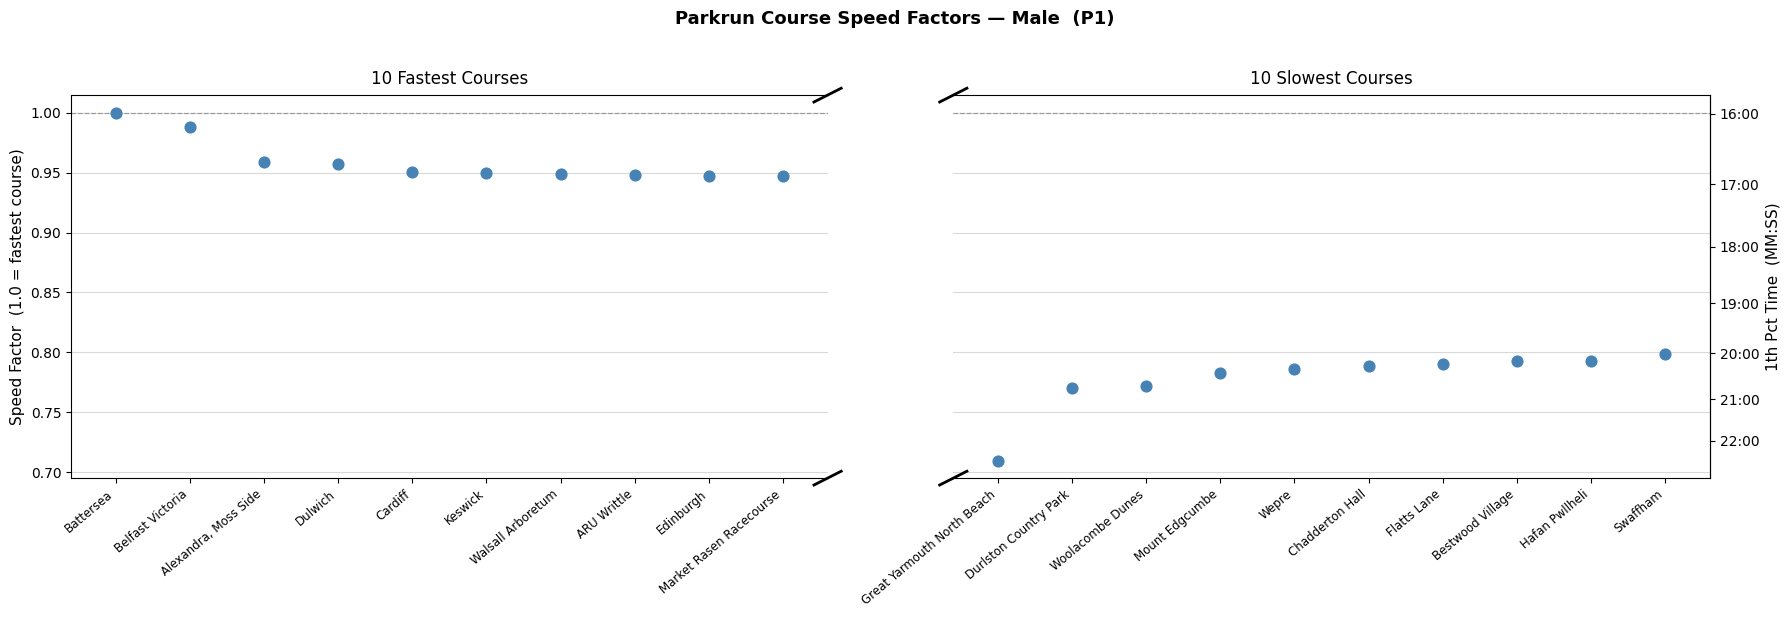

/var/folders/rx/60rbql0x49b20byhsnw62dvr0000gn/T/ipykernel_98229/2591913191.py:43: RuntimeWarning: divide by zero encountered in divide
  lambda t: p_ref / np.asarray(t, float)))


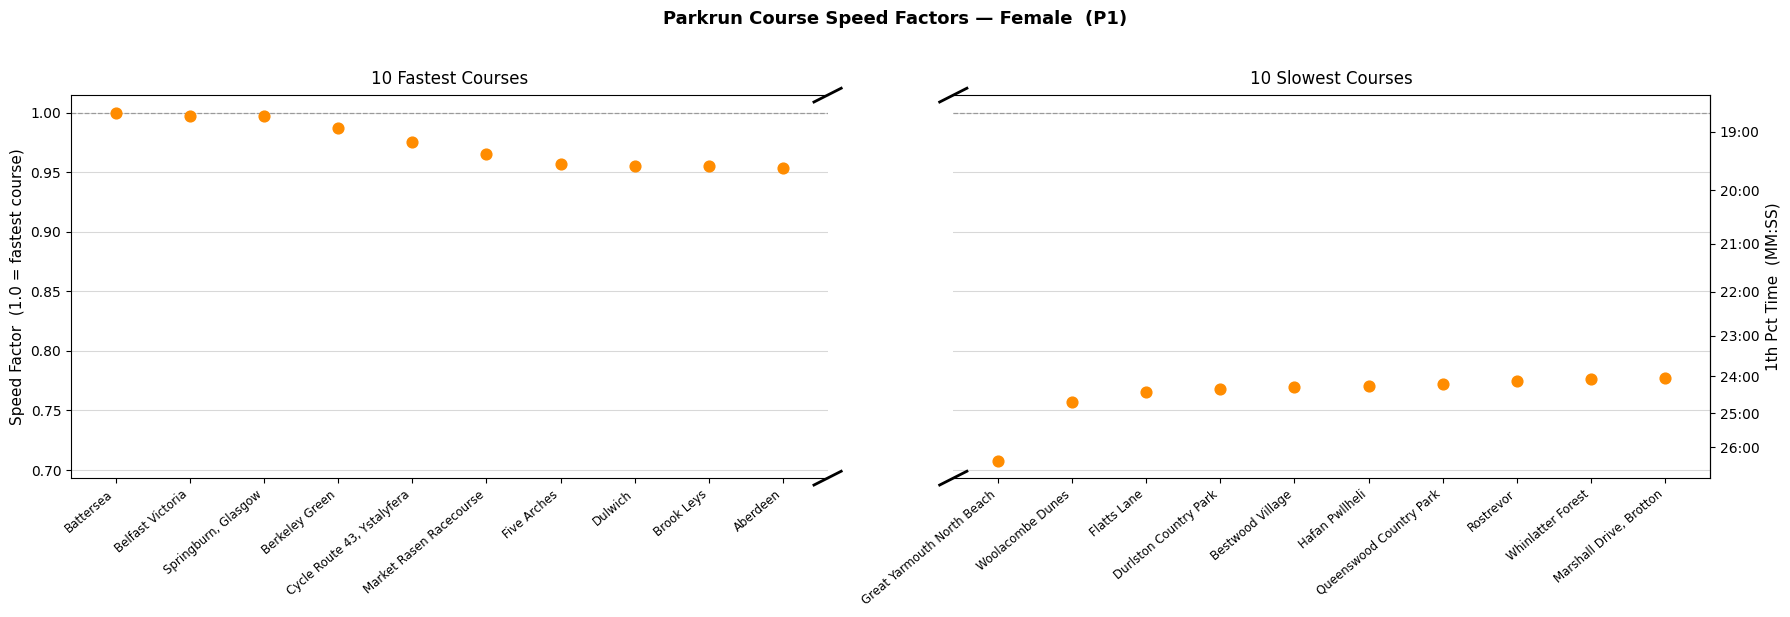

In [26]:
def plot_factors(df_g, gender, n=10):
    color = "steelblue" if gender == "Male" else "darkorange"
    p_ref = df_g["p_ref"].min()

    fastest = df_g.nlargest(n, "factor").sort_values("factor", ascending=False)
    slowest = df_g.nsmallest(n, "factor").sort_values("factor", ascending=True)

    fig, (ax_f, ax_s) = plt.subplots(
        1, 2, figsize=(18, 6), sharey=True, gridspec_kw={"width_ratios": [1, 1]}
    )
    fig.subplots_adjust(wspace=0.05)

    def _panel(ax, data):
        x = np.arange(len(data))
        ax.scatter(x, data["factor"].values, color=color, s=60, zorder=4)
        ax.axhline(1.0, color="grey", lw=0.9, ls="--", alpha=0.7, zorder=1)
        labels = [name.replace(" parkrun", "").strip() for name in data["Event Name"]]
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=40, ha="right", fontsize=8.5)
        ax.set_xlim(-0.6, len(data) - 0.4)
        ax.grid(axis="y", alpha=0.3, lw=0.8, color="grey")
        ax.set_axisbelow(True)

    _panel(ax_f, fastest)
    _panel(ax_s, slowest)

    ax_f.set_title("10 Fastest Courses", fontsize=12, pad=8)
    ax_s.set_title("10 Slowest Courses", fontsize=12, pad=8)
    ax_f.set_ylabel("Speed Factor  (1.0 = fastest course)", fontsize=11)

    # Broken-axis slashes
    d, kw = 0.018, dict(color="k", clip_on=False, lw=2, zorder=10)
    ax_f.spines["right"].set_visible(False)
    for y in (0, 1):
        ax_f.plot([1 - d, 1 + d], [y - d, y + d], transform=ax_f.transAxes, **kw)
    ax_s.spines["left"].set_visible(False)
    ax_s.tick_params(which="both", left=False)
    for y in (0, 1):
        ax_s.plot([-d, +d], [y - d, y + d], transform=ax_s.transAxes, **kw)

    # Secondary y-axis: percentile time in MM:SS
    secax = ax_s.secondary_yaxis(
        "right",
        functions=(
            lambda f: p_ref / np.asarray(f, float),
            lambda t: p_ref / np.asarray(t, float),
        ),
    )

    def fmt_p(x, _):
        m, s = divmod(round(x * 60), 60)
        return f"{m}:{s:02d}"

    secax.yaxis.set_major_formatter(mticker.FuncFormatter(fmt_p))
    secax.set_ylabel(f"{pct_label} Time  (MM:SS)", fontsize=11)

    fig.suptitle(
        f"Parkrun Course Speed Factors — {gender}  ({pct_str})",
        fontsize=13,
        fontweight="bold",
        y=1.02,
    )
    fig.tight_layout()
    plt.savefig(f"speed_factors_{gender.lower()}.png", dpi=150, bbox_inches="tight")
    plt.show()


plot_factors(men, "Male")
plot_factors(women, "Female")

## Combined (M + F) factor and sanity check

In [27]:
both = men[["Event Name", "factor"]].merge(
    women[["Event Name", "factor"]], on="Event Name", suffixes=("_men", "_women")
)
both["combined"] = (both["factor_men"] + both["factor_women"]) / 2

corr = both["factor_men"].corr(both["factor_women"])
print(f"M/F correlation: {corr:.3f}  (sanity check — should be high)")

BCOLS = {"combined": "Combined", "factor_men": "Men", "factor_women": "Women"}
print("\n=== TOP 30 FASTEST ===")
display(
    both.nlargest(30, "combined")[["Event Name"] + list(BCOLS)]
    .rename(columns=BCOLS)
    .reset_index(drop=True)
)
print("\n=== TOP 30 SLOWEST ===")
display(
    both.nsmallest(30, "combined")[["Event Name"] + list(BCOLS)]
    .rename(columns=BCOLS)
    .reset_index(drop=True)
)

M/F correlation: 0.790  (sanity check — should be high)

=== TOP 30 FASTEST ===


,Event Name,Combined,Men,Women
0,Battersea parkrun,1.0000,1.0000,1.0000
1,Belfast Victoria parkrun,0.9923,0.9876,0.9970
2,Dulwich parkrun,0.9563,0.9571,0.9555
3,Market Rasen Racecourse parkrun,0.9558,0.9467,0.9649
4,Berkeley Green parkrun,0.9514,0.9160,0.9869
5,"Springburn parkrun, Glasgow",0.9512,0.9056,0.9968
6,Keswick parkrun,0.9499,0.9494,0.9504
7,"Alexandra parkrun, Moss Side",0.9498,0.9588,0.9408
8,Elder Park parkrun,0.9446,0.9430,0.9462
9,Cardiff parkrun,0.9442,0.9504,0.9379



=== TOP 30 SLOWEST ===


,Event Name,Combined,Men,Women
0,Great Yarmouth North Beach parkrun,0.7088,0.7098,0.7078
1,Woolacombe Dunes parkrun,0.7647,0.7720,0.7573
2,Durlston Country Park parkrun,0.7692,0.7703,0.7681
3,Flatts Lane parkrun,0.7778,0.7904,0.7651
4,Bestwood Village parkrun,0.7812,0.7925,0.7698
5,Hafan Pwllheli parkrun,0.7817,0.7927,0.7707
6,Wepre parkrun,0.7826,0.7866,0.7786
7,Chadderton Hall parkrun,0.7830,0.7889,0.7772
8,Queenswood Country Park parkrun,0.7866,0.8008,0.7724
9,Mount Edgcumbe parkrun,0.7874,0.7832,0.7916


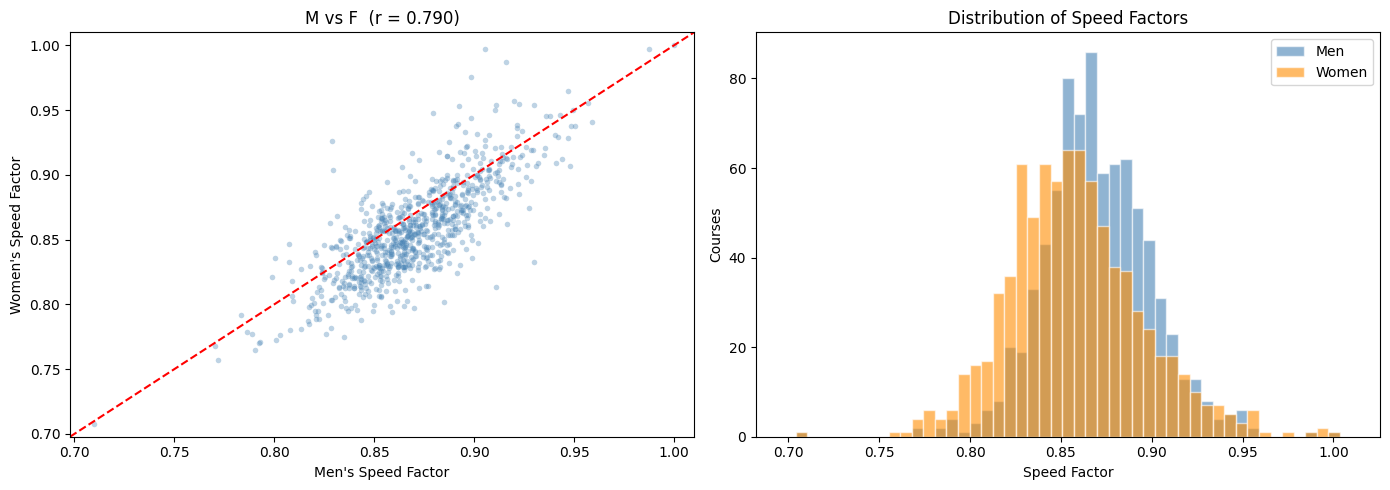

,factor_men,factor_women,combined
count,819.0000,819.0000,819.0000
mean,0.8698,0.8575,0.8637
std,0.0300,0.0372,0.0318
min,0.7098,0.7078,0.7088
25%,0.8513,0.8323,0.8439
50%,0.8679,0.8554,0.8605
75%,0.8886,0.8781,0.8824
max,1.0000,1.0000,1.0000


In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(
    both["factor_men"],
    both["factor_women"],
    alpha=0.35,
    s=16,
    color="steelblue",
    linewidths=0,
)
lim = both[["factor_men", "factor_women"]].stack().agg(["min", "max"]).values + [
    -0.01,
    0.01,
]
ax.plot(lim, lim, "r--", lw=1.5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_xlabel("Men's Speed Factor")
ax.set_ylabel("Women's Speed Factor")
ax.set_title(f"M vs F  (r = {corr:.3f})")

ax = axes[1]
bins = np.linspace(both[["factor_men", "factor_women"]].min().min() - 0.01, 1.01, 50)
ax.hist(
    both["factor_men"],
    bins=bins,
    alpha=0.6,
    label="Men",
    color="steelblue",
    edgecolor="white",
)
ax.hist(
    both["factor_women"],
    bins=bins,
    alpha=0.6,
    label="Women",
    color="darkorange",
    edgecolor="white",
)
ax.set_xlabel("Speed Factor")
ax.set_ylabel("Courses")
ax.set_title("Distribution of Speed Factors")
ax.legend()

plt.tight_layout()
plt.show()

display(both[["factor_men", "factor_women", "combined"]].describe())